**MPPI Optimization Loop Demo**

# **Installations**

In [1]:
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout v0

Cloning into 'balloon-outreach'...
remote: Enumerating objects: 873, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 873 (delta 130), reused 128 (delta 110), pack-reused 666 (from 1)
Receiving objects: 100% (873/873), 70.79 MiB | 14.43 MiB/s, done.
Resolving deltas: 100% (523/523), done.
/content/balloon-outreach
Already on 'v0'
Your branch is up to date with 'origin/v0'.


In [2]:
# Install required packages
!pip install -r requirements.txt
!pip install -U gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.6 MB/s eta 0:00:00
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=f3e9ae28dedf0424973c4e2eded9c110428d03784ee0bf3bfa9ac20861ed81e0
  Stored in directory: /root/.cache/pip/wheels/17/3c/41/2bc89719586c2a5c53e9a527daa76a968a1288315c1ae2d904
Successfully built reverse_geocoder


In [3]:
# Download ERA5 data
import gdown
file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
url = f"https://drive.google.com/uc?id={file_id}"
output = "era5_data.nc"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf
From (redirected): https://drive.google.com/uc?id=1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf&confirm=t&uuid=b744fb5e-88d0-4706-8ce3-69d27c9fdddc
To: /content/balloon-outreach/era5_data.nc
100%|██████████| 1.65G/1.65G [00:19<00:00, 86.3MB/s]


'era5_data.nc'

# **Sampling Demo**

Below is a walkthrough of one iteration of the MPPI optimization loop for a given control sequence:

In [ ]:
import os
import sys
import numpy as np

os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from main_mppi import run_episode
from env.balloon_env import BalloonEnvironment
from agent.mppi_agent import MPPIAgent
from env.visualize import plot_accs_vels_samples, plot_alts_movement_samples, plot_vels_averaged, plot_costs_samples
import matplotlib.pyplot as plt

initial_lat = 50
initial_lon = 10
initial_alt = 12.0
target_lat = 5
target_lon = 10
target_alt = 12
max_steps = 100
horizon = 30
num_samples = 10
acc_bounds = -0.5,0.5
env = BalloonEnvironment(target_lat=target_lat, target_lon=target_lon,target_alt=target_alt,dt=600)
agent = MPPIAgent(horizon=horizon,num_samples=num_samples, acc_bounds=acc_bounds, visualize=False)


control_sequence = np.zeros(horizon) # our plan of velocities for the balloon

# 1. Sample random control sequences
vertical_velocity = env.balloon.vertical_velocity
base_sequence = control_sequence.copy()
# Add noise to create samples
noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))

acc_samples = base_sequence + noise
acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])

accumulated_acc_samples = np.cumsum(acc_samples, axis=1)
vel_samples = vertical_velocity + accumulated_acc_samples

# Clip to action bounds
vel_samples = np.clip(vel_samples, agent.vel_bounds[0], agent.vel_bounds[1])


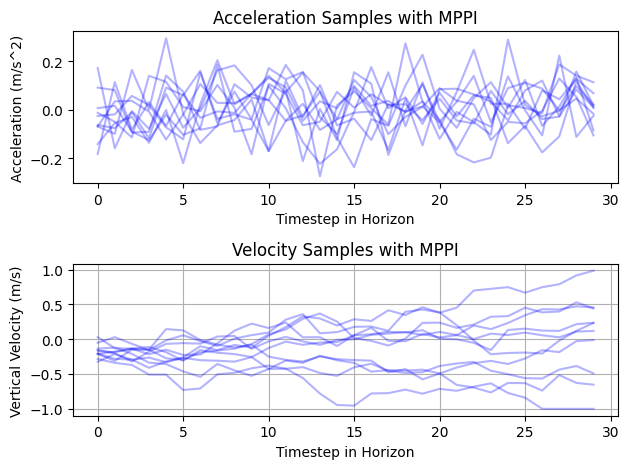

In [ ]:
plot_accs_vels_samples(acc_samples, vel_samples, horizon)

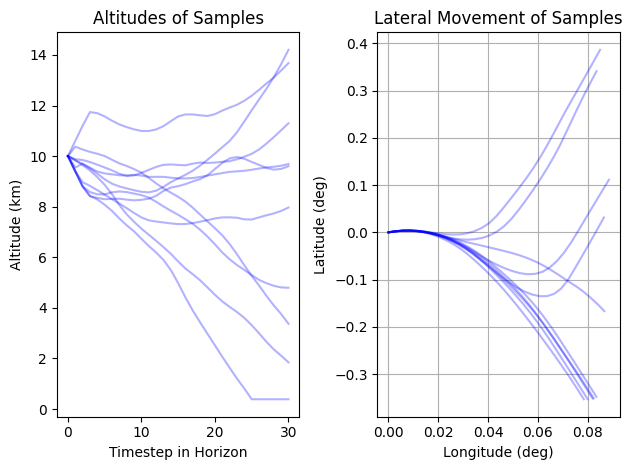

In [ ]:
# Use sampled vertical velocities to track horizontal and vertical movement
vert_movement = []
lateral_movement = []
for sample in vel_samples:
  alts = []
  paths = []
  alts.append(env.balloon.alt)
  paths.append((env.balloon.lon, env.balloon.lat))
  for action in sample:
    state, reward, done, reason = env.step(action)
    alts.append(env.balloon.alt)
    paths.append((env.balloon.lon, env.balloon.lat))
  vert_movement.append(alts)
  lateral_movement.append(paths)
  env.reset()
  
plot_alts_movement_samples(vert_movement, lateral_movement, horizon)

Costs are: [234.19659757 190.10571713 338.04704655 338.0230098  268.93448034
 246.74758066 337.72837402 337.99934497 337.97696226 337.99495268]
Weights are: [7.10516102e-20 1.00000000e+00 5.62207958e-65 5.75885332e-65
 5.82241456e-35 2.51623515e-25 7.73205100e-65 5.89676091e-65
 6.03023460e-65 5.92271816e-65]


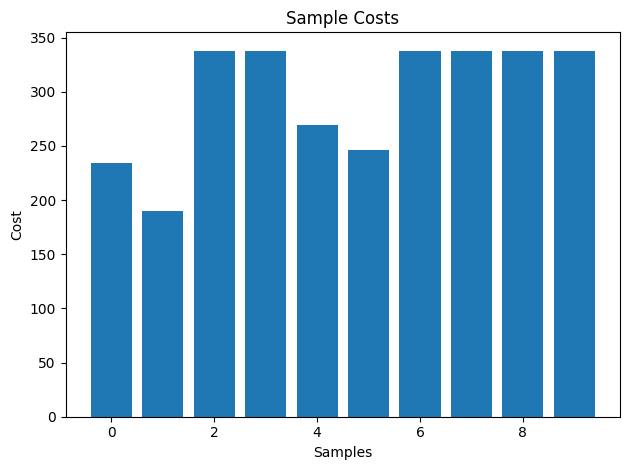

In [ ]:

# 2. Calculate cost of each sequence
costs = []
for i in range(num_samples):
    # Evaluate one sample control sequence
    cost = 0.0
    vel_sample = vel_samples[i]
    acc_sample = acc_samples[i]

    cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
    costs.append(cost)

costs = np.array(costs)

# Check for NaN costs and replace with high cost
if np.any(~np.isfinite(costs)):
    print("Warning: NaN costs detected, replacing with high cost")
    costs = np.where(np.isfinite(costs), costs, 1e6)
print(f"Costs are: {costs}")

# 3. Use the costs to calculate weights for each sampled sequence
# Shift costs to prevent numerical issues
costs_shifted = costs - np.min(costs)

# Compute weights using softmax
weights = np.exp(-1 * costs_shifted)
weights = weights / np.sum(weights)

# Check for NaN weights
if np.any(~np.isfinite(weights)):
    print("Warning: NaN weights detected, using uniform weights")
    weights = np.ones_like(weights) / len(weights)
print(f"Weights are: {weights}")

# Graph the costs. If the trajectories are similar, the costs and weights will also be similar
plot_costs_samples(costs)

Final control sequence: [-0.13602995 -0.12044793 -0.21108283 -0.33725821 -0.35810494 -0.46221863
 -0.53973038 -0.35569403 -0.44709354 -0.52674813 -0.42865971 -0.42307639
 -0.55754213 -0.78122478 -0.94497345 -0.95482928 -0.78001117 -0.77481927
 -0.72408305 -0.78302901 -0.71352944 -0.7415214  -0.68231017 -0.63408997
 -0.77258353 -0.84004336 -1.         -1.         -1.         -1.        ]


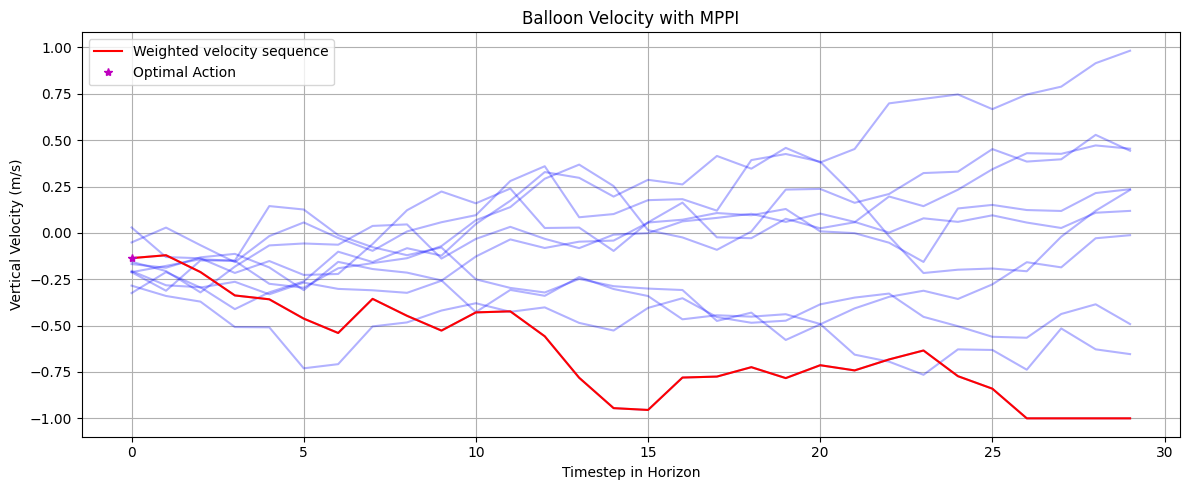

In [ ]:
# 4. Compute optimal control sequence by weighted averaging
optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
# Check for NaN in optimal control
if not np.isfinite(optimal_sequence[0]):
    print("Warning: NaN optimal control detected, using zero action")
    optimal_sequence[0] = 0.0

# 5. Update control sequence
#control_sequence = np.roll(optimal_sequence, -1)
#control_sequence[-1] = optimal_sequence[0]
control_sequence = optimal_sequence

print(f"Final control sequence: {control_sequence}")
# Plot final trajectory
plot_vels_averaged(vel_samples, control_sequence, horizon)

The graph should change slightly each time you run it since the generated samples are random. The optimal action the agent selects is the first velocity from the control sequence.

# **Iterative Optimization**

MPPI normally optimizes once per timestep. However, we can repeat this optimization loop `num_iterations` times to try to get a better control sequence. For each loop, once we get the optimal control sequence, we pass this in as the initial control sequence to re-optimize.

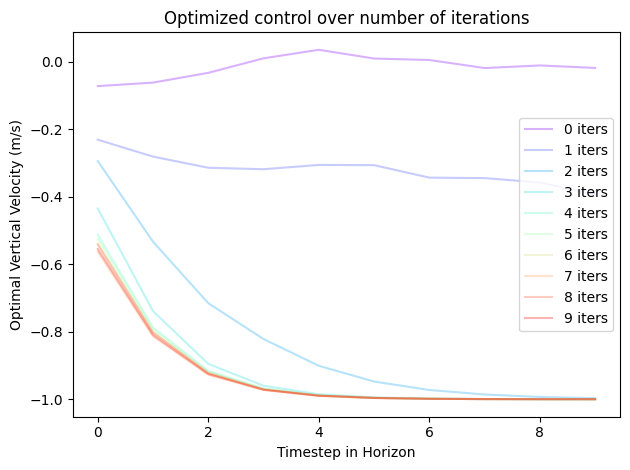

In [74]:
from matplotlib.pyplot import cm
import numpy as np

# Optional: Modify the MPPI parameters
initial_lat = 50
initial_lon = 10
initial_alt = 12.0
target_lat = 5
target_lon = 10
target_alt = 12
max_steps = 100
horizon = 10 # how long each plan is
num_samples = 10 # how many random plans should we make
num_iterations = 10 # how many times should we make the random plans
acc_bounds = -0.5,0.5
env = BalloonEnvironment(target_lat=target_lat, target_lon=target_lon,target_alt=target_alt,dt=600)
agent = MPPIAgent(horizon=horizon,num_samples=num_samples, num_iterations=num_iterations, acc_bounds=acc_bounds, visualize=False)


control_sequence = np.zeros(horizon)
color = iter(cm.rainbow(np.linspace(0, 1, agent.num_iterations)))
all_costs = []

# Repeat optimization loop
for num in range(agent.num_iterations):
  vertical_velocity = env.balloon.vertical_velocity
  base_sequence = control_sequence.copy()
  noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))
  # Different sampling than above example
  # Optional: decay noise over time to reduce extreme accumulation
  decay = np.linspace(1.0, 0.3, agent.horizon)
  noise *= decay

  acc_samples = base_sequence + noise
  acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])

  vel_samples = np.zeros_like(acc_samples)
  vel_samples[:, 0] = vertical_velocity + acc_samples[:, 0]

  for t in range(1, agent.horizon):
      vel_samples[:, t] = vel_samples[:, t - 1] + acc_samples[:, t]

  # Soft clip velocities
  vmax = agent.vel_bounds[1]
  vel_samples = np.tanh(vel_samples / vmax) * vmax
  costs = []
  for i in range(agent.horizon):
      # Evaluate one sample control sequence
      cost = 0.0
      trajectory = []
      vel_sample = vel_samples[i]
      acc_sample = acc_samples[i]

      cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
      costs.append(cost)

  costs = np.array(costs)
  all_costs.append(np.mean(costs))

  # Check for NaN costs and replace with high cost
  if np.any(~np.isfinite(costs)):
      print("Warning: NaN costs detected, replacing with high cost")
      costs = np.where(np.isfinite(costs), costs, 1e6)

  costs_shifted = costs - np.min(costs)
  weights = np.exp(-1 * costs_shifted)
  weights = weights / np.sum(weights)

  # Check for NaN weights
  if np.any(~np.isfinite(weights)):
      print("Warning: NaN weights detected, using uniform weights")
      weights = np.ones_like(weights) / len(weights)

  optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
  # Check for NaN in optimal control
  if not np.isfinite(optimal_sequence[0]):
      print("Warning: NaN optimal control detected, using zero action")
      optimal_sequence[0] = 0.0

  control_sequence = optimal_sequence
  c = next(color)
  pltlabel = f"{num} iters"
  plt.plot(control_sequence, c=c, alpha=0.3, label=pltlabel)
  #print(f"Optimized control sequence: {control_sequence}")

plt.title('Optimized control over number of iterations')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Optimal Vertical Velocity (m/s)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

Try to adjust the `num_iterations` variable to see how the optimized control sequence changes! Does it seem to converge?

The minimum cost is 111.65099139414906
Minimum averaged cost control sequence: Plan 8


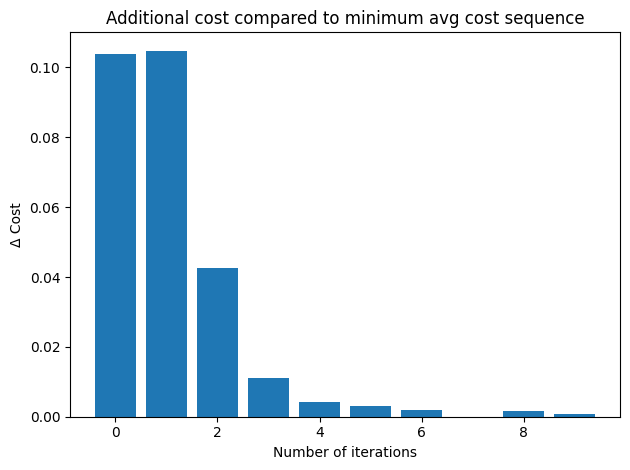

In [75]:
# Graph differences in costs.
print(f"The minimum cost is {min(all_costs)}")
all_costs = all_costs - min(all_costs)
all_costs = np.array(all_costs)
print(f"Minimum averaged cost control sequence: Plan {np.argmin(all_costs) + 1}")
plt.bar([i for i in range(agent.num_iterations)], all_costs)
plt.title('Additional cost compared to minimum avg cost sequence')
plt.xlabel('Number of iterations')
plt.ylabel('Δ Cost')
plt.tight_layout()
plt.show()
plt.close()